<a href="https://colab.research.google.com/github/mudrap17/Data-Mining-Assignment/blob/main/DataMiningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/archive-2

/content/drive/MyDrive/archive-2


In [ ]:
%ls brain_tumor_mri/new_dataset

bt_images/  labels.pickle  training_data.pickle


In [3]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn import cluster
from zipfile import ZipFile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import os
import random
from sklearn.model_selection import train_test_split

In [4]:
import pickle
training_data = pickle.load(open('brain_tumor_mri/new_dataset/training_data.pickle', 'rb'))

In [69]:
random.shuffle(training_data)
print("No. of images:" + str(len(training_data)))
print("Shape of image 1:" + str(training_data[0][0].shape))
print("Class of image 1:"+ str(training_data[0][1]))

No. of images:3064
Shape of image 1:(512, 512, 3)
Class of image 1:2


In [70]:
total_data_len = len(training_data)
classes = ['Meningioma', 'Glioma', 'Pitutary']
n_classes = len(classes)

x_raw = []
y_raw = []

for i in training_data:
    x_raw.append(i[0])
    y_raw.append(i[1])

y_raw = list(np.asarray(y_raw)-np.ones(total_data_len,dtype=np.int))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


In [71]:
from collections import Counter

classes_count=Counter(y_raw)
print(classes_count)

Counter({1: 1426, 2: 930, 0: 708})


Number of scans with Meningioma : 708 , Glioma : 1426 , Pitutary : 930


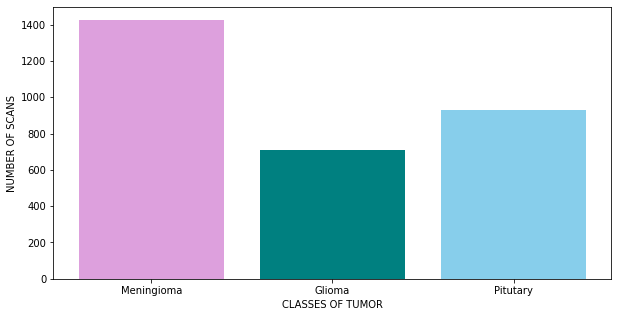

In [8]:
print(f'Number of scans with Meningioma : {classes_count[0]} , Glioma : {classes_count[1]} , Pitutary : {classes_count[2]}')            
fig = plt.figure(figsize = (10, 5))
plt.bar(classes,classes_count.values(),color=['plum','teal','skyblue'])
plt.xlabel("CLASSES OF TUMOR")
plt.ylabel("NUMBER OF SCANS")
plt.show()

In [72]:
# https://note.nkmk.me/en/python-opencv-numpy-rotate-flip/

def augment_data(counter, max_number, class_name,x_raw,y_raw):
    n=len(x_raw)
    # while we don't have a lot of images
    while counter < max_number:
        # loop through each image in list
        for i in range(n):
            # check the number of images again
            #print(i)
            if counter < max_number and y_raw[i]==class_name:
                # make scaling
                imgAug = np.flipud(x_raw[i])
                
                # add new image and it's label
                x_raw.append(imgAug)
                y_raw.append(class_name)
  
                #print(Counter(y_raw)[y_raw[i]])
                # recalculate a counter
                counter = Counter(y_raw)[class_name]
            else:
              continue
                

In [73]:


(X, x_val , Y, y_val) = train_test_split(x_raw, y_raw, stratify=y_raw,random_state=42,
                                                    test_size=0.2)
(x_train, x_test, y_train, y_test) =  train_test_split(X, Y,
                                                    test_size=0.2,random_state=42)
print(f"x_train examples: {len(x_train)}\nx_test examples: {len(x_test)}\nx_val examples: {len(x_val)}")


x_train examples: 1960
x_test examples: 491
x_val examples: 613


In [74]:
count_classes=Counter(y_train)
print(count_classes)

max_count=max(count_classes.values())
print(max_count)

for k in count_classes.keys():
  if count_classes[k]!=max_count:
     augment_data(count_classes[k],max_count,k,x_train,y_train)

print(Counter(y_train))

Counter({1: 913, 2: 590, 0: 457})
913
Counter({2: 913, 1: 913, 0: 913})


In [75]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train1 = lb.fit_transform(y_train)
y_val1=lb.fit_transform(y_val)
y_test1=lb.fit_transform(y_test)

In [76]:
len(x_train)

2739

In [77]:
transform = T.Compose(
    [T.ToPILImage(),
     T.ToTensor(),
     T.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])


In [78]:
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
        
train_data = ImageDataset(x_train, y_train1, transform)
val_data = ImageDataset(x_val, y_val1, transform)
test_data = ImageDataset(x_test, y_test1, transform)

In [79]:
BATCH_SIZE=15
epochs=5
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        #self.conv4 = nn.Conv2d(32,)
        self.fc1 = nn.Linear(32 * 60 * 60 , 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=115200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)


In [ ]:
o1=(512-5+0)/1 +1
o2= o1//2
o3= (o2-5+0)/1 +1
o4= o3//2
o5= (o4-5+0)/1 +1
o6=o5//2


In [81]:
import torch.optim as optim
import time
from tqdm import tqdm

model=Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def fit(model, dataloader):
    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        #print((data[1].size()))
        data, target = data[0], data[1]
        #print(torch.max(target,0))
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, torch.max(target,1)[1])
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == torch.max(target,1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")
    
    return loss, accuracy

In [82]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0], data[1]
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
        
        return loss, accuracy
    
def test(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, target = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == torch.max(target, 1)[1]).sum().item()
    return correct, total

In [83]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

Training on 2739 examples, validating on 613 examples...
Epoch 1 of 5
Training


183it [04:27,  1.46s/it]


Train Loss: 0.0486, Train Acc: 64.99
Validating


41it [00:24,  1.66it/s]


Val Loss: 0.0435, Val Acc: 69.82
Epoch 2 of 5
Training


183it [04:28,  1.47s/it]


Train Loss: 0.0294, Train Acc: 82.04
Validating


41it [00:24,  1.67it/s]


Val Loss: 0.0253, Val Acc: 84.18
Epoch 3 of 5
Training


183it [04:23,  1.44s/it]


Train Loss: 0.0163, Train Acc: 90.62
Validating


41it [00:25,  1.64it/s]


Val Loss: 0.0176, Val Acc: 88.91
Epoch 4 of 5
Training


183it [04:25,  1.45s/it]


Train Loss: 0.0101, Train Acc: 94.30
Validating


41it [00:24,  1.70it/s]


Val Loss: 0.0162, Val Acc: 90.86
Epoch 5 of 5
Training


183it [04:24,  1.45s/it]


Train Loss: 0.0050, Train Acc: 97.19
Validating


41it [00:24,  1.65it/s]

Val Loss: 0.0168, Val Acc: 91.84
24.22954931259155 minutes


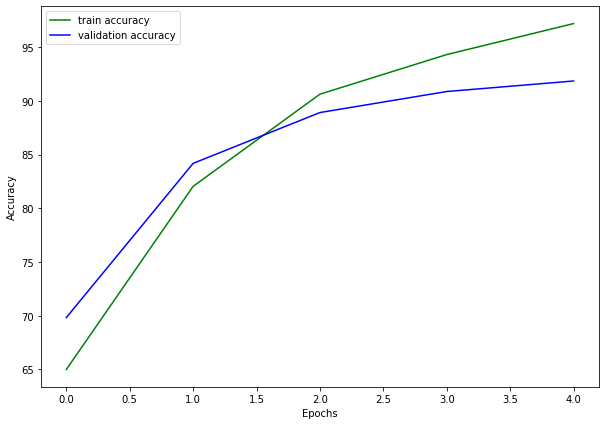

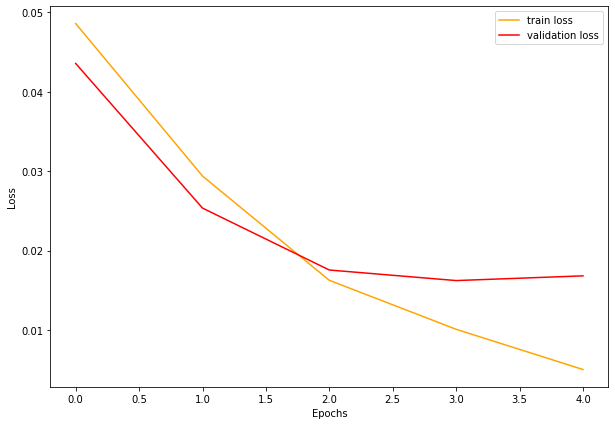

In [84]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [13]:
class ConvEncoder(nn.Module):
    def __init__(self):
        super(ConvEncoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 32), 5x5 kernels
        self.conv1 = nn.Conv2d(3, 32, 5,stride=3)  
       
        self.conv2 = nn.Conv2d(32, 16, 3,stride=2)
        
        self.conv3 = nn.Conv2d(16, 2, 3)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
    
    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x) # compressed representation
        return x
        

In [41]:
o1=(512-5+0)/3 +1
o2= o1//2
o3= (o2-3+0)/2 +1
o4= o3//2
o5= (o4-2+0)/1 +1
o6=o5//2
print(o6)

10.0


In [43]:
model=ConvEncoder()
x_train2=[]
for x in x_train:
  new_image=transform(x)
  new_features=model(new_image)
  #print(new_features.shape)
  #new_features=torch.flatten(new_features)
  new_features=new_features.detach().numpy()
  x_train2.append(new_features)
  #break

In [44]:
x_val2=[]
for x in x_val:
  new_image=transform(x)
  new_features=model(new_image)
  #new_features=torch.flatten(new_features)
  new_features=new_features.detach().numpy()
  x_val2.append(new_features)

In [33]:

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
def KNN(label,x_train,y_train,x_test,y_test,k):
    
    clf = KNeighborsClassifier(k)
    
    clf.fit(x_train,y_train)
    
    y_pred = clf.predict(x_test)
    
    print("Accuracy of {} KNN is %{}".format(label,accuracy_score(y_pred=y_pred,y_true=y_test)))
    
    

In [45]:
KNN("Encoder+",x_train2,y_train,x_val2,y_val,2)

Accuracy of Encoder+ KNN is %0.8466557911908646


In [46]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.2).fit(x_train2, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1.2).fit(x_train2, y_train)

In [47]:
poly_pred = poly.predict(x_val2)
rbf_pred = rbf.predict(x_val2)

In [48]:
poly_accuracy = accuracy_score(y_val, poly_pred)
poly_f1 = f1_score(y_val, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  83.20
F1 (Polynomial Kernel):  83.42


In [49]:
rbf_accuracy = accuracy_score(y_val, rbf_pred)
rbf_f1 = f1_score(y_val, rbf_pred, average='weighted')
print('Accuracy (Rbf Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (Rbf Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (Rbf Kernel):  70.96
F1 (Rbf Kernel):  70.59


In [ ]:
4